# Kmeans experiments

This notebook calculates the speedup between the sequential and parallel implementation.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

## Loading datasets

This section loads the datasets execution results used for the experiments.

In [2]:
datasets = ['rice', 'htru2', 'wesad']

### Sequential

Loading the sequential dataframes.

In [3]:
dfs_sequential: list[pd.DataFrame] = []
for dataset in datasets:
    dfs_sequential.append(pd.read_csv(f'../kmeans-sequential/experiments/{dataset}_experiment_result.csv'))
df_sequential = pd.concat(dfs_sequential, join='inner')

In [4]:
df_sequential.head()

,iteration,dataset,time,converged_at
0,0,rice,0.000953,8
1,1,rice,0.001162,11
2,2,rice,0.001160,11
3,3,rice,0.000856,8
4,4,rice,0.000971,9


### Parallel

Loading the parallel dataframes.

In [5]:
dfs_omp: list[pd.DataFrame] = []
for dataset in datasets:
    dfs_omp.append(pd.read_csv(f'../kmeans-openmp/experiments/{dataset}_experiment_result.csv'))
df_omp = pd.concat(dfs_omp, join='inner')

In [6]:
df_omp.head()

,iteration,dataset,time,converged_at
0,0,rice,0.174021,11
1,1,rice,0.102154,9
2,2,rice,0.000437,6
3,3,rice,0.000375,4
4,4,rice,0.000959,10


## Comparing execution time

This section compares the execution time between the parallel and 

/tmp/ipykernel_308660/3473945970.py:14: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(
/tmp/ipykernel_308660/3473945970.py:14: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(
/tmp/ipykernel_308660/3473945970.py:14: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(


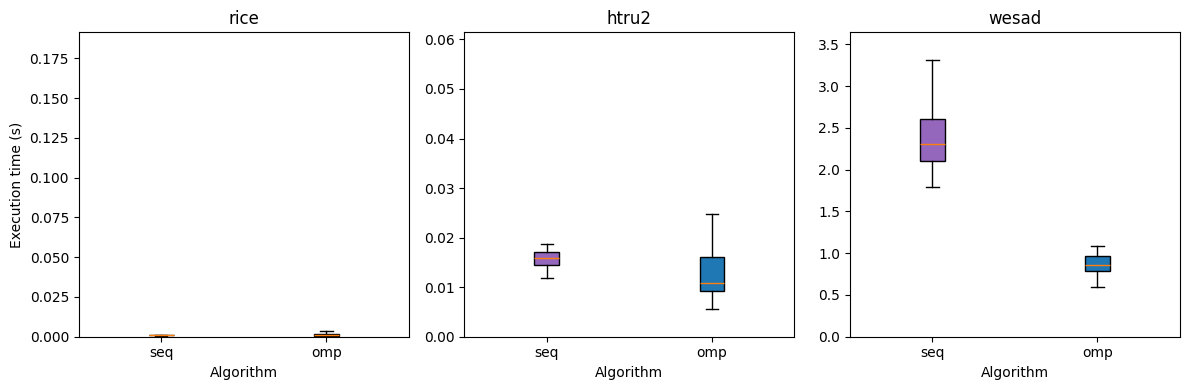

In [10]:
datasets = ['rice','htru2','wesad']
df_omp['algorithm'] = 'omp'
df_sequential['algorithm'] = 'sequential'
df = pd.concat([df_omp, df_sequential], ignore_index=True)

fig, axes = plt.subplots(1, 3, figsize=(12,4), sharey=False)

for ax, ds in zip(axes, datasets):
    sub = df[df.dataset == ds]
    seq = sub[sub.algorithm=='sequential']['time'].values
    omp = sub[sub.algorithm=='omp']['time'].values

    # draw boxplots
    bp = ax.boxplot(
        [seq, omp],
        labels=['seq','omp'],
        patch_artist=True,
        showfliers=False
    )
    # color them
    bp['boxes'][0].set_facecolor('C4')
    bp['boxes'][1].set_facecolor('C0')

    ax.set_title(ds)
    ax.set_xlabel('Algorithm')

    # auto-scale y to just cover this dataset’s range
    top = max(seq.max(), omp.max()) * 1.1
    ax.set_ylim(0, top)

axes[0].set_ylabel('Execution time (s)')
plt.tight_layout()
plt.show()
# plt.savefig('boxplot.png')

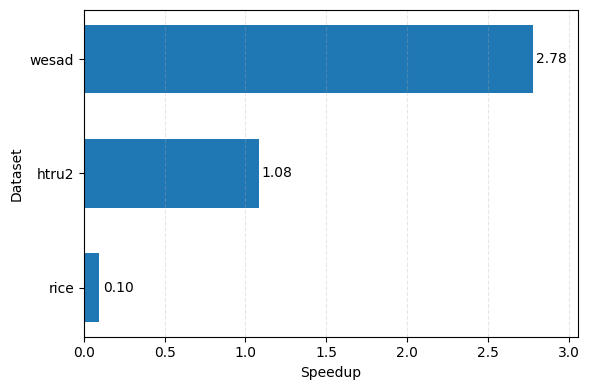

In [15]:
mean_times = (
    df
    .groupby(['dataset','algorithm'])['time']
    .mean()
    .unstack('algorithm')
    .loc[datasets]
)

# Speedup = tempo sequencial / tempo omp
speedup = mean_times['sequential'] / mean_times['omp']

# 2) Plot horizontal de barras
speedup_sorted = speedup.sort_values()

fig, ax = plt.subplots(figsize=(6,4))
bars = ax.barh(speedup_sorted.index, speedup_sorted.values, height=0.6)

ax.set_xlabel('Speedup')
ax.set_ylabel('Dataset')
ax.set_xlim(0, speedup_sorted.max() * 1.1)

# Anotar valores ao final de cada barra
for bar in bars:
    w = bar.get_width()
    ax.text(w + 0.02, bar.get_y() + bar.get_height()/2,
            f'{w:.2f}', va='center')

plt.grid(axis='x', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()
plt.savefig('speedup.png')

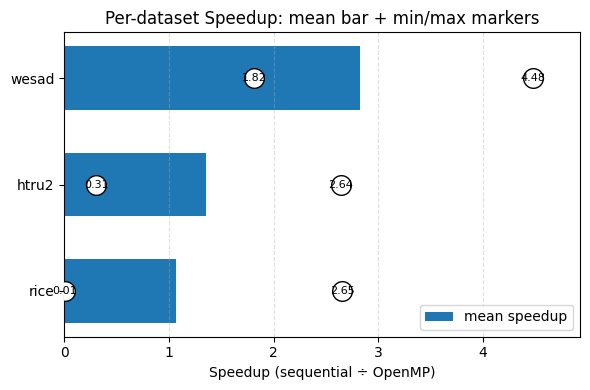

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1) load & compute per-run speedup
datasets = ['rice','htru2','wesad']
def load_and_tag(path, label):
    df = pd.read_csv(path)
    df['algorithm'] = label
    return df

dfs = []
for d in datasets:
    dfs.append(load_and_tag(f'../kmeans-sequential/experiments/{d}_experiment_result.csv','sequential'))
    dfs.append(load_and_tag(f'../kmeans-openmp/experiments/{d}_experiment_result.csv','omp'))
df = pd.concat(dfs, ignore_index=True)

df['time'] = pd.to_numeric(df['time'], errors='coerce')
df = df.dropna(subset=['time'])

seq = df[df.algorithm=='sequential'][['dataset','iteration','time']].rename(columns={'time':'t_seq'})
omp = df[df.algorithm=='omp'][['dataset','iteration','time']].rename(columns={'time':'t_omp'})
merged = pd.merge(seq, omp, on=['dataset','iteration'])
merged['speedup'] = merged['t_seq'] / merged['t_omp']

stats = merged.groupby('dataset')['speedup'].agg(['min','mean','max']).loc[datasets]

# 2) plot
y_pos = np.arange(len(datasets))
means = stats['mean'].values
mins = stats['min'].values
maxs = stats['max'].values

fig, ax = plt.subplots(figsize=(6,4))
ax.barh(y_pos, means, height=0.6, color='C0', label='mean speedup')

# overlay min/max markers with labels
for i in range(len(datasets)):
    # min marker
    ax.scatter(mins[i], i,
               marker='o', s=200,
               facecolors='white', edgecolors='black', zorder=3)
    ax.text(mins[i], i, f"{mins[i]:.2f}",
            va='center', ha='center', zorder=4, fontsize=8)

    # max marker
    ax.scatter(maxs[i], i,
               marker='o', s=200,
               facecolors='white', edgecolors='black', zorder=3)
    ax.text(maxs[i], i, f"{maxs[i]:.2f}",
            va='center', ha='center', zorder=4, fontsize=8)

ax.set_yticks(y_pos)
ax.set_yticklabels(stats.index)
ax.set_xlabel('Speedup (sequential ÷ OpenMP)')
ax.set_title('Per-dataset Speedup: mean bar + min/max markers')
ax.set_xlim(0, maxs.max()*1.1)
ax.grid(axis='x', linestyle='--', alpha=0.4)

# legend
ax.legend(loc='lower right')
plt.tight_layout()
plt.show()


In [23]:
stats

,min,mean,max
dataset,,,
rice,0.005476,1.071662,2.654462
htru2,0.306906,1.358204,2.641977
wesad,1.817803,2.829280,4.480436
